<a href="https://colab.research.google.com/github/Jarifakhatunmoitry/Weather_Assignment_Curtin/blob/main/starter_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌦️ WeatherWise – Starter Notebook

Welcome to your **WeatherWise** project notebook! This scaffold is designed to help you build your weather advisor app using Python, visualisations, and AI-enhanced development.

---

📄 **Full Assignment Specification**  
See [`ASSIGNMENT.md`](ASSIGNMENT.md) or check the LMS for full details.

📝 **Quick Refresher**  
A one-page summary is available in [`resources/assignment-summary.md`](resources/assignment-summary.md).

---

🧠 **This Notebook Structure is Optional**  
You’re encouraged to reorganise, rename sections, or remove scaffold cells if you prefer — as long as your final version meets the requirements.

✅ You may delete this note before submission.



## 🧰 Setup and Imports

This section imports commonly used packages and installs any additional tools used in the project.

- You may not need all of these unless you're using specific features (e.g. visualisations, advanced prompting).
- The notebook assumes the following packages are **pre-installed** in the provided environment or installable via pip:
  - `requests`, `matplotlib`, `pyinputplus`
  - `fetch-my-weather` (for accessing weather data easily)
  - `hands-on-ai` (for AI logging, comparisons, or prompting tools)

If you're running this notebook in **Google Colab**, uncomment the following lines to install the required packages.


In [5]:
!pip install fetch-my-weather
!pip install hands-on-ai
!pip install pyinputplus
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.5/155.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.0/71.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.0/352.0 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.7/517.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 456.8/456.8 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 128.4 MB/s eta 0:00:00
  Attempting uninstall: jiter
    Found exist

In [6]:
import os

os.environ['HANDS_ON_AI_SERVER'] = 'http://ollama.serveur.au'
os.environ['HANDS_ON_AI_MODEL'] = 'granite3.2'
os.environ['HANDS_ON_AI_API_KEY'] = input('Enter your API key: ')

Enter your API key: 3


## 📦 Setup and Configuration
Import required packages and setup environment.

In [7]:
import requests
import matplotlib.pyplot as plt
import pyinputplus as pyip

# Libraries for Fetching Weather Data
from fetch_my_weather import get_weather
from hands_on_ai.chat import get_response

## 🌤️ Weather Data Functions

In [8]:
from datetime import datetime, timezone
from collections import defaultdict
import requests

API_KEY = "84da7cc3f2d9ede0095a61917cf3b0fa"

def get_weather_data(location, forecast_days=5):
    # Clamp days between 1 and 5
    try:
        n_days = int(forecast_days)
    except (TypeError, ValueError):
        n_days = 5
    n_days = 1 if n_days < 1 else 5 if n_days > 5 else n_days

    # Geocode to coordinates
    geo_resp = requests.get(
        "http://api.openweathermap.org/geo/1.0/direct",
        params={"q": location, "limit": 1, "appid": API_KEY},
    ).json()

    if not geo_resp:
        print(f"Location '{location}' not found.")
        return None

    lat_deg, lon_deg = geo_resp[0]["lat"], geo_resp[0]["lon"]

    # Current conditions
    now_json = requests.get(
        "https://api.openweathermap.org/data/2.5/weather",
        params={"lat": lat_deg, "lon": lon_deg, "units": "metric", "appid": API_KEY},
    ).json()

    # 5-day / 3-hour forecast
    prog_json = requests.get(
        "https://api.openweathermap.org/data/2.5/forecast",
        params={"lat": lat_deg, "lon": lon_deg, "units": "metric", "appid": API_KEY},
    ).json()

    # Group forecast entries by UTC date (string)
    day_buckets = {}
    for slot in prog_json.get("list", []):
        day_key = datetime.fromtimestamp(slot["dt"], tz=timezone.utc).strftime("%Y-%m-%d")
        day_buckets.setdefault(day_key, []).append(slot)

    # Summarise per day
    days = []
    for day_key, slots in day_buckets.items():
        if len(days) >= n_days:
            break

        temps = [s["main"]["temp"] for s in slots if "main" in s]
        wx_text = slots[0]["weather"][0]["description"] if slots and slots[0].get("weather") else None
        precip_total_mm = sum((s.get("rain", {}).get("3h") or 0) for s in slots)
        pop_vals = [(s.get("pop") or 0) for s in slots]
        pop_avg_pct = (sum(pop_vals) / len(pop_vals) * 100) if pop_vals else 0

        day_summary = {
            "dateLabel": day_key,
            "highTempC": max(temps) if temps else None,
            "lowTempC": min(temps) if temps else None,
            "meanTempC": (sum(temps) / len(temps)) if temps else None,
            "conditions": wx_text,
            "rainfallMM": precip_total_mm,
            "rainChancePct": pop_avg_pct
        }
        days.append(day_summary)

    # Weather Results
    weather_package = {
        "location": location,
        "currentStatus": {
            "temperatureC": now_json.get("main", {}).get("temp"),
            "conditions": (now_json.get("weather") or [{}])[0].get("description"),
            "humidityPct": now_json.get("main", {}).get("humidity"),
            "feelsLikeC": now_json.get("main", {}).get("feels_like"),
            "windSpeedKmph": now_json.get("wind", {}).get("speed"),
        },
        "forecastDays": days
    }

    return weather_package


## 📊 Visualisation Functions

In [9]:
import matplotlib.pyplot as plt
import pandas as pd


from datetime import datetime

def create_temperature_visualisation(weather_bundle, date_limits=None, output_mode='display'):

    daily_data = weather_bundle.get("forecastDays", [])
    if not daily_data:
        raise ValueError("No forecast data available")

    # Optional filtering by date range
    if date_limits:
        start_dt = datetime.strptime(date_limits[0], "%Y-%m-%d")
        end_dt = datetime.strptime(date_limits[1], "%Y-%m-%d")
        daily_data = [
            d for d in daily_data
            if start_dt <= datetime.strptime(d["dateLabel"], "%Y-%m-%d") <= end_dt
        ]

    if not daily_data:
        raise ValueError("No forecast data available in the given date range")

    # Extract values for plotting
    day_labels = [d["dateLabel"] for d in daily_data]
    highs = [d["highTempC"] for d in daily_data]
    lows = [d["lowTempC"] for d in daily_data]
    means = [d["meanTempC"] for d in daily_data]

    # Plotting
    plt.figure(figsize=(9, 5))
    plt.plot(day_labels, highs, color='red', marker='o', label='High (°C)')
    plt.plot(day_labels, lows, color='blue', marker='o', label='Low (°C)')
    plt.plot(day_labels, means, color='orange', marker='o', label='Mean (°C)', linestyle='--')

    plt.xlabel("Date")
    plt.ylabel("Temperature (°C)")
    plt.title(f"Temperature Forecast for {weather_bundle.get('location', 'Unknown')}")
    plt.xticks(rotation=30)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()

    if output_mode == 'display':
        plt.show()
    elif output_mode == 'save':
        filename = "temperature_forecast.png"
        plt.savefig(filename)
        return filename
    else:
        raise ValueError("Invalid output_mode. Use 'display' or 'save'.")

In [10]:
def create_precipitation_visualisation(weather_bundle, output_mode='display'):
    """
    Visualise daily precipitation (mm) and chance of rain (%) from forecast data.

    Args:
        weather_bundle (dict): Weather dataset containing 'forecastDays'.
        output_mode (str): 'display' to show plot, 'save' to save PNG.
    """
    # Extract forecastDays list
    daily_data = weather_bundle.get("forecastDays", [])
    if not daily_data:
        raise ValueError("No forecast data available")

    # Prepare data for plotting
    day_labels = [d["dateLabel"] for d in daily_data]
    rain_amounts = [d["rainfallMM"] for d in daily_data]
    rain_chances = [d["rainChancePct"] for d in daily_data]

    # Create figure and axes
    fig, ax_precip = plt.subplots(figsize=(8, 5))

    # Bar chart for precipitation
    ax_precip.bar(day_labels, rain_amounts, color='blue', alpha=0.6, label="Rainfall (mm)")
    ax_precip.set_xlabel("Date")
    ax_precip.set_ylabel("Rainfall (mm)", color='blue')
    ax_precip.tick_params(axis='y', labelcolor='blue')

    # Line chart for chance of rain (second axis)
    ax_chance = ax_precip.twinx()
    ax_chance.plot(day_labels, rain_chances, color='red', marker='o', label="Chance of Rain (%)")
    ax_chance.set_ylabel("Chance of Rain (%)", color='red')
    ax_chance.tick_params(axis='y', labelcolor='red')

    # Title and legends
    plt.title(f"Precipitation Forecast for {weather_bundle.get('location', 'Unknown')}")
    ax_precip.legend(loc="upper left")
    ax_chance.legend(loc="upper right")

    plt.tight_layout()

    if output_mode == 'display':
        plt.show()
    elif output_mode == 'save':
        filename = "precipitation_forecast.png"
        plt.savefig(filename)
        return filename
    else:
        raise ValueError("Invalid output_mode. Use 'display' or 'save'.")




## 🤖 Natural Language Processing

In [16]:
import re
from datetime import datetime, timedelta

def parse_weather_question(question):
    question = question.lower().strip()

    result = {
        "location": None,
        "time_period": "today",
        "attribute": "general"
    }

    match = re.search(r'\b(?:in|of|for)\s+([a-z\s]+?)(?:\s+(today|tomorrow|next|weather|temperature|rain|forecast|$))', question)
    if match:
        result["location"] = match.group(1).strip()
    else:
        # fallback: last word if it looks like a city
        tokens = question.split()
        if len(tokens) > 1:
            result["location"] = tokens[-1]

    if "tomorrow" in question:
        result["time_period"] = "tomorrow"
    elif m := re.search(r'next\s+(\d+)\s+days', question):
        result["time_period"] = f"next_{m.group(1)}_days"

    # ---- Extract weather attribute ----
    if "temperature" in question:
        result["attribute"] = "temperature"
    elif any(word in question for word in ["rain", "precipitation"]):
        result["attribute"] = "precipitation"
    elif "forecast" in question or "weather" in question:
        result["attribute"] = "forecast"

    return result


## 🧭 User Interface

In [12]:
# Define menu functions using pyinputplus or ipywidgets here

## 🧩 Main Application Logic

In [19]:
def generate_weather_response(parsed_question, weather_data):
    # Handle missing or malformed data
    forecast_data = weather_data.get("forecastDays")
    if not weather_data or not forecast_data:
        return "Sorry, I couldn't retrieve weather data at this time."

    location = parsed_question.get("location", weather_data.get("location", "your location"))
    time_period = parsed_question.get("time_period", "today")
    attribute = parsed_question.get("attribute", "general")

    # Helper to get a forecast by index
    def get_day_forecast(index):
        if index < len(forecast_data):
            return forecast_data[index]
        return None

    # Optionally visualize
    create_temperature_visualisation(weather_data)
    create_precipitation_visualisation(weather_data)

    response = ""

    # ====== TODAY ======
    if time_period == "today":
        day_forecast = get_day_forecast(0)
        if not day_forecast:
            return f"Sorry, I don't have today's forecast for {location}."

        if attribute == "temperature":
            response = (f"The temperature today ranges from "
                        f"{day_forecast['lowTempC']:.1f}°C to {day_forecast['highTempC']:.1f}°C "
                        f"(avg {day_forecast['meanTempC']:.1f}°C).")
        elif attribute == "precipitation":
            response = (f"There’s a {day_forecast['rainChancePct']}% chance of rain "
                        f"with about {day_forecast['rainfallMM']} mm expected.")
        else:
            response = (f"Today's weather: {day_forecast['conditions']}, "
                        f"temp {day_forecast['lowTempC']:.1f}–{day_forecast['highTempC']:.1f}°C, "
                        f"rain {day_forecast['rainfallMM']} mm.")

    # ====== TOMORROW ======
    elif time_period == "tomorrow":
        day_forecast = get_day_forecast(1)
        if not day_forecast:
            return f"Sorry, I don't have tomorrow's forecast for {location}."

        if attribute == "temperature":
            response = (f"Tomorrow in {location}, temperatures will range from "
                        f"{day_forecast['lowTempC']:.1f}°C to {day_forecast['highTempC']:.1f}°C "
                        f"(avg {day_forecast['meanTempC']:.1f}°C).")
        elif attribute == "precipitation":
            response = (f"Tomorrow there’s a {day_forecast['rainChancePct']}% chance of rain "
                        f"with {day_forecast['rainfallMM']} mm expected.")
        else:
            response = (f"Tomorrow in {location}: {day_forecast['conditions']}, "
                        f"temp {day_forecast['lowTempC']:.1f}–{day_forecast['highTempC']:.1f}°C, "
                        f"rain {day_forecast['rainfallMM']} mm.")

    # ====== NEXT X DAYS ======
    elif time_period.startswith("next_"):
        days = int(time_period.split("_")[1])
        forecast_list = forecast_data[:days]
        if not forecast_list:
            return f"Sorry, I don't have the forecast for the next {days} days in {location}."

        lines = [f"Weather forecast for the next {days} days in {location}:"]
        for day in forecast_list:
            lines.append(f"{day['dateLabel']}: {day['conditions']}, "
                         f"{day['lowTempC']:.1f}–{day['highTempC']:.1f}°C, "
                         f"rain {day['rainfallMM']} mm.")
        response = "\n".join(lines)

    else:
        response = "Sorry, I couldn't understand the time period you asked for."

    return response


## 🧪 Testing and Examples

🌤️ Weather Assistant
Ask me about the weather (e.g., 'What will the temperature be in Paris tomorrow?'):
> what is temperature in dhaka today


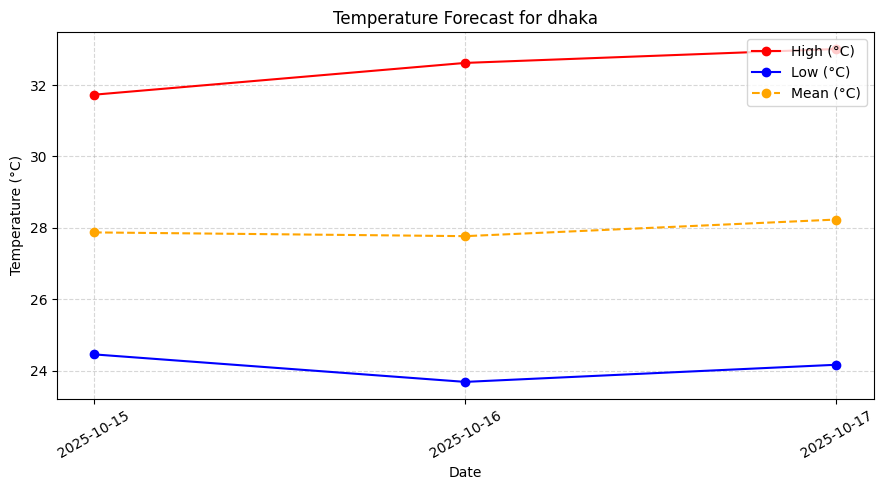

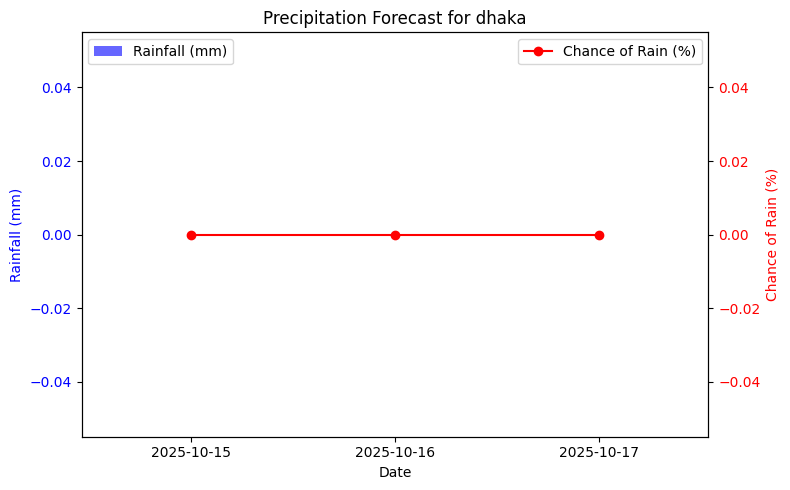


👉 The temperature today ranges from 24.5°C to 31.7°C (avg 27.9°C).


In [21]:
# Include sample input/output for each function
def main():
    print("🌤️ Weather Assistant")
    question = input("Ask me about the weather (e.g., 'What will the temperature be in Paris tomorrow?'):\n> ")

    parsed = parse_weather_question(question)
    # print(parsed.get('location'))
    location = parsed.get("location")

    weather_data = get_weather_data(location, forecast_days=3)
    # print(weather_data)
    if not weather_data:
        print("Could not fetch weather data.")
        return

    response = generate_weather_response(parsed, weather_data)
    print("\n👉 " + response)


# Example run
if __name__ == "__main__":
    main()


## 🗂️ AI Prompting Log (Optional)
Add markdown cells here summarising prompts used or link to AI conversations in the `ai-conversations/` folder.